In [1]:
from sqlalchemy import create_engine, MetaData, Table, inspect
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import math

In [3]:
def new_engine(dialect, server, database, user=None, password=None, integrated_security=True):
    if integrated_security:
        # For Windows authentication
        eng = f"{dialect}://{server}/{database}?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server"
    else:
        # For SQL Server authentication
        eng = f"{dialect}://{user}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server"
    print(eng)
    return create_engine(eng)

In [4]:
# For Windows authentication
# Replace the server argument with the Server Name found when logging into SQL Server Management Studio 
# OR
# For SQL Server authentication
# Replace the server, user and password argument with the Server Name, username and password
engine = new_engine('mssql', 'DESKTOP-069IOG8', 'AdventureWorks2022', integrated_security=True)

mssql://DESKTOP-069IOG8/AdventureWorks2022?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server


In [5]:
print(type(engine))

<class 'sqlalchemy.engine.base.Engine'>


In [6]:
connection = engine.connect()

In [7]:
print(type(connection))

<class 'sqlalchemy.engine.base.Connection'>


In [8]:
# Calculate Number Of Employees
NumberOfEmployees = """

SELECT COUNT(BusinessEntityID) AS NumberOfEmployees
FROM HumanResources.Employee

"""

result = pd.read_sql(NumberOfEmployees, engine)
print(result)

   NumberOfEmployees
0                290


In [9]:
# Calculate Number Of Departments
NumberOfEmployees = """

SELECT COUNT(DepartmentID) AS NumberOfDepartments
FROM HumanResources.Department

"""

result = pd.read_sql(NumberOfEmployees, engine)
print(result)

   NumberOfDepartments
0                   16


In [10]:
# Calculate Total Sale over time
df = pd.read_sql(sql="SELECT SUM(LineTotal) AS TotalRevenue FROM Sales.SalesOrderDetail", con=connection)

# Correct the data format 
pd.options.display.float_format = '{:,.0f}'.format
df.head()

,TotalRevenue
0,"109,846,381"


In [11]:
# Find the first and the last order dates 
FirstOrderDate_LastOrderDate = """

SELECT
    MIN(OrderDate) AS FirstOrderDate,
    MAX(OrderDate) AS LastOrderDate
FROM
    Sales.SalesOrderHeader;

"""

result = pd.read_sql(FirstOrderDate_LastOrderDate, engine)
print(result)

  FirstOrderDate LastOrderDate
0     2011-05-31    2014-06-30


In [12]:
# Find Total Sales and Total Orders Per Months

df = pd.read_sql(sql = """
SELECT
    YEAR(OrderDate) AS Year,
    MONTH(OrderDate) AS Month,
    SUM(SubTotal) AS TotalSalesByMonth,
	COUNT(*) AS OrderCount
FROM
    Sales.SalesOrderHeader
WHERE
    YEAR(OrderDate) BETWEEN 2011 AND 2014
GROUP BY
    YEAR(OrderDate), MONTH(OrderDate)
ORDER BY
    YEAR(OrderDate), MONTH(OrderDate)
"""
, con=connection)
df.head()

,Year,Month,TotalSalesByMonth,OrderCount
0,2011,5,"503,806",43
1,2011,6,"458,911",141
2,2011,7,"2,044,600",231
3,2011,8,"2,495,817",250
4,2011,9,"502,074",157


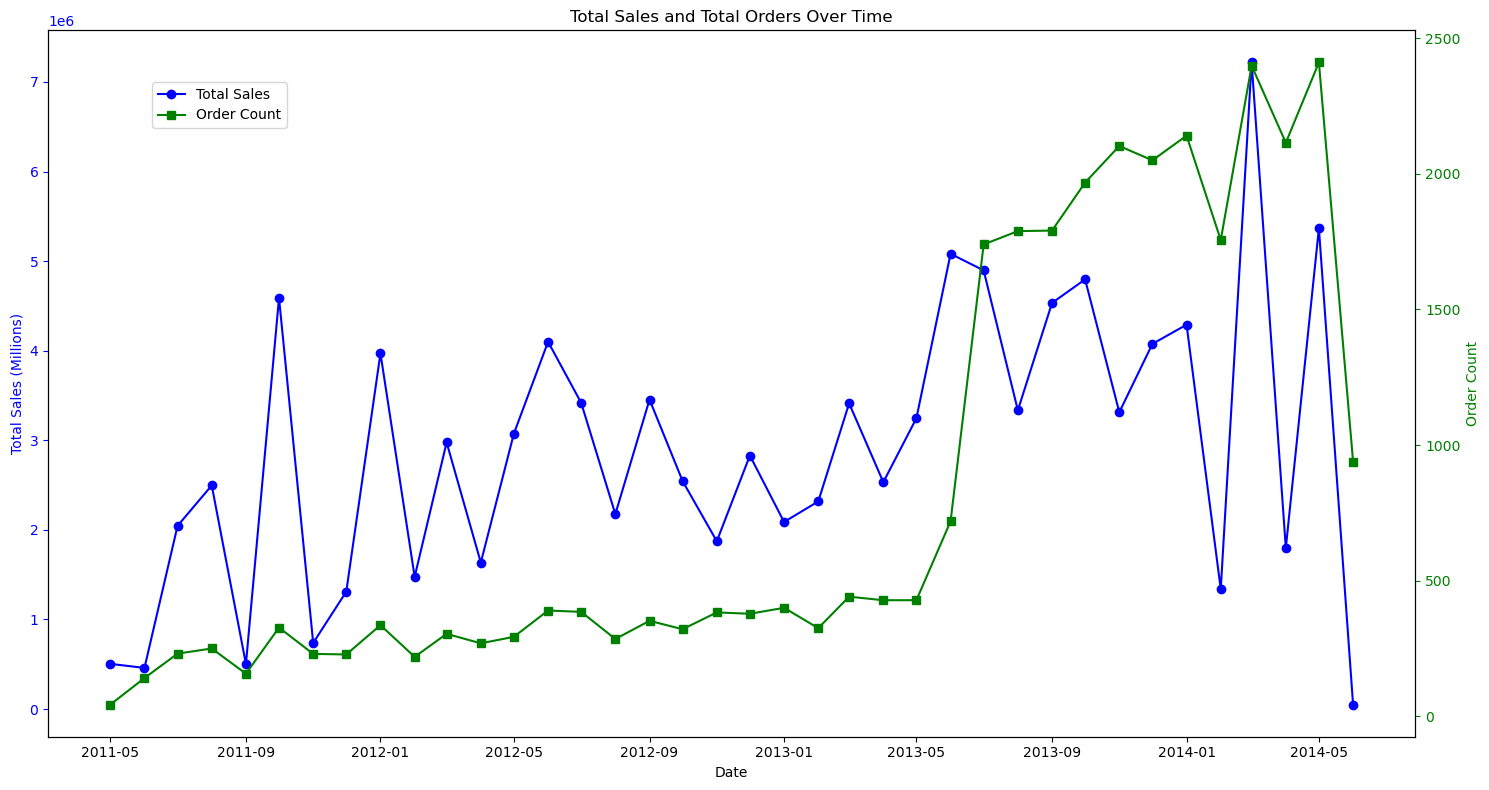

In [13]:
df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))

fig, ax1 = plt.subplots(figsize=(15, 8))

ax1.plot(df['Date'], df['TotalSalesByMonth'], color='blue', marker='o', label='Total Sales')
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Sales (Millions)', color='blue')
ax1.tick_params('y', colors='blue')

ax2 = ax1.twinx()
ax2.plot(df['Date'], df['OrderCount'], color='green', marker='s', label='Order Count')
ax2.set_ylabel('Order Count', color='green')
ax2.tick_params('y', colors='green')

plt.title('Total Sales and Total Orders Over Time')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

plt.xticks(rotation=45, ha='right')

plt.show()

In [14]:
# Calculate Total Sale / Total Orders and Sales Growth Percentage/ Order Growth Percentage by Period
SalesGrowthPercentage_OrderGrowthPercentage = """
WITH PreviousTotalSales_PreviousTotalOrders_CTE AS (
    SELECT
        OrderPeriod,
        SUM(SubTotal) AS TotalSales,
        COUNT(*) AS TotalOrders,
        AVG(SubTotal) AS MeanSalesAmount,
        LAG(SUM(SubTotal)) OVER (ORDER BY OrderPeriod) AS PreviousTotalSales,
        LAG(COUNT(SalesOrderID)) OVER (ORDER BY OrderPeriod) AS PreviousTotalOrders
    FROM (
        SELECT
            SubTotal,
            SalesOrderID,
            CASE
                WHEN OrderDate >= '2011-05-31' AND OrderDate <= '2012-05-29' THEN '2011-05-31 to 2012-05-29'
                WHEN OrderDate >= '2012-05-30' AND OrderDate <= '2013-05-29' THEN '2012-05-30 to 2013-05-29'
                WHEN OrderDate >= '2013-05-30' AND OrderDate <= '2014-06-30' THEN '2013-05-30 to 2014-06-30'
            END AS OrderPeriod
        FROM
            Sales.SalesOrderHeader
    ) AS SalesData
    GROUP BY
        OrderPeriod
)

SELECT
    OrderPeriod,
    TotalSales,
    TotalOrders,
    CASE
        WHEN PreviousTotalSales IS NULL THEN 0  
        ELSE ((TotalSales - PreviousTotalSales) / PreviousTotalSales) * 100
    END AS SalesGrowthPercentage,
    CASE
        WHEN PreviousTotalOrders IS NULL THEN 0  
        ELSE ((TotalOrders - PreviousTotalOrders) * 100.0 / PreviousTotalOrders) 
    END AS OrderGrowthPercentage
FROM
    PreviousTotalSales_PreviousTotalOrders_CTE
ORDER BY
    OrderPeriod;

"""

result = pd.read_sql(SalesGrowthPercentage_OrderGrowthPercentage, engine)
result

,OrderPeriod,TotalSales,TotalOrders,SalesGrowthPercentage,OrderGrowthPercentage
0,2011-05-31 to 2012-05-29,"23,360,526",2945,0,0
1,2012-05-30 to 2013-05-29,"33,683,805",4477,44,52
2,2013-05-30 to 2014-06-30,"52,802,051",24043,57,437


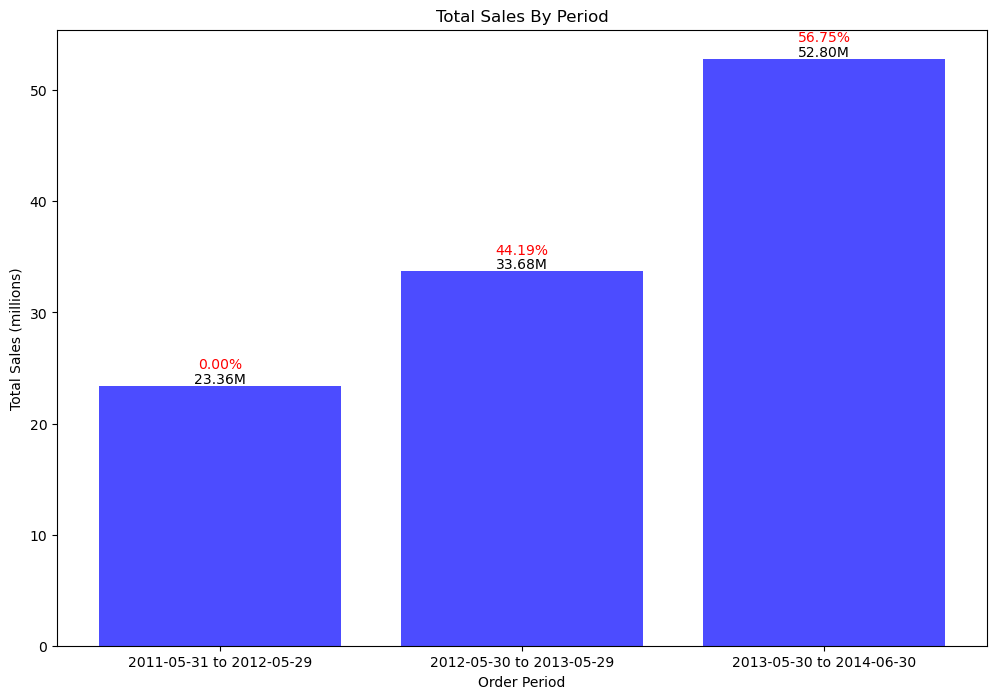

In [15]:
# Visualize Total Sales by Period
order_periods = result['OrderPeriod']
total_sales = result['TotalSales'] / 1e6  # Convert total revenue to millions
growth_percentage = result['SalesGrowthPercentage']

plt.figure(figsize=(12, 8))
bars = plt.bar(order_periods, total_sales, color='blue', alpha=0.7)

plt.xlabel('Order Period')
plt.ylabel('Total Sales (millions)')
plt.title('Total Sales By Period')

for bar, growth_percent in zip(bars, growth_percentage):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}M', ha='center', va='bottom')

# Add text on each bar for growth percentage
for bar, growth_percent in zip(bars, growth_percentage):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 1.3, f'{growth_percent:.2f}%', ha='center', va='bottom', color='red')

plt.show()

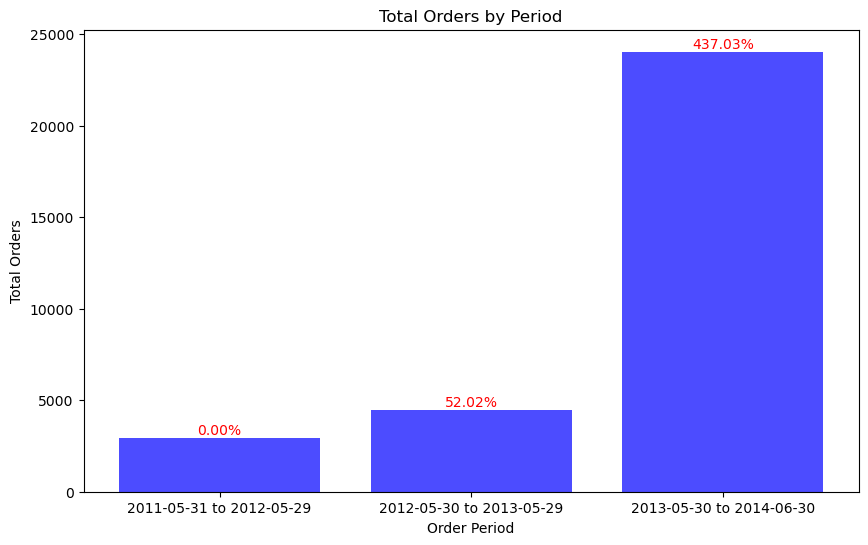

In [16]:
# Visualize Total Orders by Period
order_periods = result['OrderPeriod']
total_sales = result['TotalOrders'] 
growth_percentage = result['OrderGrowthPercentage']

plt.figure(figsize=(10, 6))
bars = plt.bar(order_periods, total_sales, color='blue', alpha=0.7)

plt.xlabel('Order Period')
plt.ylabel('Total Orders')
plt.title('Total Orders by Period')

# Add text on each bar for growth percentage
for bar, growth_percent in zip(bars, growth_percentage):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 1.3, f'{growth_percent:.2f}%', ha='center', va='bottom', color='red')

plt.show()

In [17]:
# Calculate Total Sale / Total Orders / Number Of Customers by Customer Type

TotalCustomers_TotalSales_TotalOrder_OverTime = """

WITH TotalCustomers_TotalSales_TotalOrder AS (
    SELECT
        CustomerID,
        COUNT(SalesOrderID) AS TotalOrders,
        SUM(SubTotal) AS TotalSales,
        CASE
            WHEN OnlineOrderFlag = 0 THEN 'Stores'
            WHEN OnlineOrderFlag = 1 THEN 'Individuals'
        END AS CustomerType
    FROM
        Sales.SalesOrderHeader
    GROUP BY
        CustomerID,
        CASE
            WHEN OnlineOrderFlag = 0 THEN 'Stores'
            WHEN OnlineOrderFlag = 1 THEN 'Individuals'
        END
)
SELECT
    CustomerType,
    COUNT(CustomerID) AS NumberOfCustomers,
    SUM(TotalSales) AS TotalSales,
    SUM(TotalOrders) AS TotalOrders,
    SUM(TotalSales) / SUM(TotalOrders) AS MeanOrder
FROM
    TotalCustomers_TotalSales_TotalOrder
GROUP BY
    CustomerType
ORDER BY
    CustomerType;

"""

result = pd.read_sql(TotalCustomers_TotalSales_TotalOrder_OverTime, engine)
result

,CustomerType,NumberOfCustomers,TotalSales,TotalOrders,MeanOrder
0,Individuals,18484,"29,358,677",27659,"1,061"
1,Stores,635,"80,487,704",3806,"21,148"


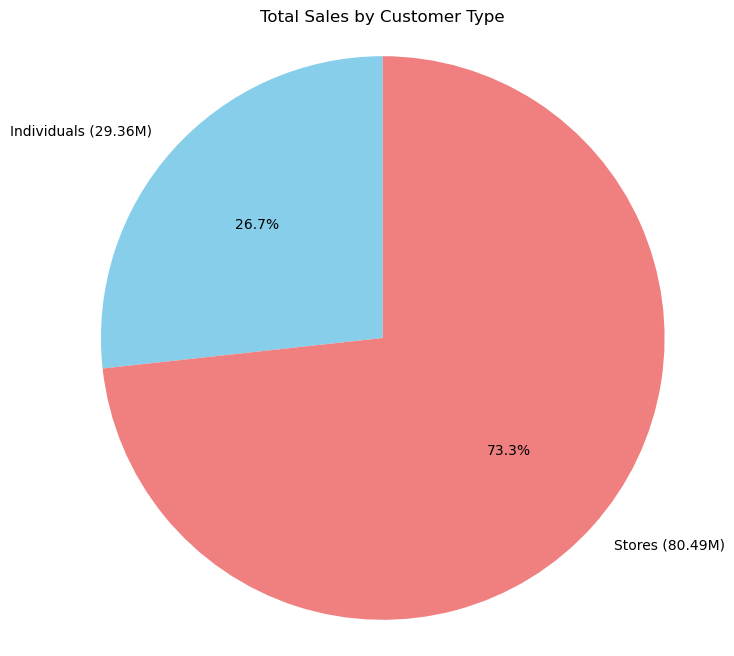

In [18]:
labels = result['CustomerType']
sizes = result['TotalSales']

# Convert total sales to millions
sizes_in_millions = sizes / 1e6

plt.figure(figsize=(8, 8))
plt.pie(sizes_in_millions, labels=[f'{label} ({size:.2f}M)' for label, size in zip(labels, sizes_in_millions)], autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'])
plt.title('Total Sales by Customer Type')
plt.axis('equal')  

plt.show()

In [19]:
#Find Number of Store Customers by Period

Number_of_StoreCustomers_By_Periods = """

WITH TotalCustomers_TotalSales_TotalOrder AS (
SELECT
    CustomerID,
    COUNT(SalesOrderID) AS TotalOrders,
    SUM(SubTotal) AS TotalSales,
    CASE
        WHEN OrderDate >= '2011-05-31' AND OrderDate <= '2012-05-29' AND OnlineOrderFlag = 0 THEN 'Store Customers First Period'
        WHEN OrderDate >= '2012-05-30' AND OrderDate <= '2013-05-29' AND OnlineOrderFlag = 0 THEN 'Store Customers Second Period'
        WHEN OrderDate >= '2013-05-30' AND OrderDate <= '2014-06-30' AND OnlineOrderFlag = 0 THEN 'Store Customers Third Period'
END AS Period
FROM
    Sales.SalesOrderHeader
GROUP BY
    CustomerID,
    CASE
        WHEN OrderDate >= '2011-05-31' AND OrderDate <= '2012-05-29' AND OnlineOrderFlag = 0 THEN 'Store Customers First Period'
        WHEN OrderDate >= '2012-05-30' AND OrderDate <= '2013-05-29' AND OnlineOrderFlag = 0 THEN 'Store Customers Second Period'
        WHEN OrderDate >= '2013-05-30' AND OrderDate <= '2014-06-30' AND OnlineOrderFlag = 0 THEN 'Store Customers Third Period'
    END
)
SELECT [Period],
	COUNT(CustomerID) AS NumberOfCustomers
FROM TotalCustomers_TotalSales_TotalOrder
WHERE [Period] IS NOT NULL
GROUP BY [Period]
ORDER BY [Period]
"""

result = pd.read_sql(Number_of_StoreCustomers_By_Periods, engine)

print(result)

                          Period  NumberOfCustomers
0   Store Customers First Period                208
1  Store Customers Second Period                365
2   Store Customers Third Period                493


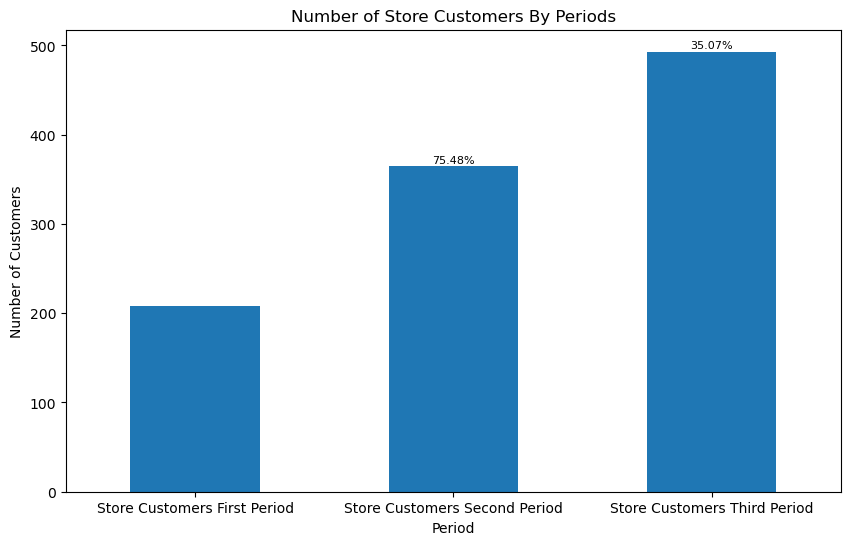

In [20]:
result['Period'] = result['Period'].astype('category')

fig, ax = plt.subplots(figsize=(10, 6))

# Stacked bar chart with rotated x-axis labels
result.set_index('Period').plot(kind='bar', stacked=True, ax=ax, legend=False, rot=0)

# Calculate percentage growth and display text labels on the plot
for i in range(1, len(result)):
    current_period = result['NumberOfCustomers'].iloc[i]
    prev_period = result['NumberOfCustomers'].iloc[i - 1]
    growth_percentage = ((current_period - prev_period) / prev_period) * 100

    ax.text(
        i,
        current_period + 1,
        f'{growth_percentage:.2f}%',
        ha='center',
        va='bottom',
        fontsize=8  
    )

ax.set_xlabel('Period')
ax.set_ylabel('Number of Customers')
ax.set_title('Number of Store Customers By Periods')

plt.show()

In [21]:
#Find Number of Individual Customers by Period

Number_of_IndividualCustomers_By_Periods = """

WITH TotalCustomers_TotalSales_TotalOrder AS (
SELECT
    CustomerID,
    COUNT(SalesOrderID) AS TotalOrders,
    SUM(SubTotal) AS TotalSales,
    CASE
        WHEN OrderDate >= '2011-05-31' AND OrderDate <= '2012-05-29' AND OnlineOrderFlag = 1 THEN 'Individuals First Period'
        WHEN OrderDate >= '2012-05-30' AND OrderDate <= '2013-05-29' AND OnlineOrderFlag = 1 THEN 'Individuals Second Period'
        WHEN OrderDate >= '2013-05-30' AND OrderDate <= '2014-06-30' AND OnlineOrderFlag = 1 THEN 'Individuals Third Period'
    END AS Period
FROM
    Sales.SalesOrderHeader
GROUP BY
    CustomerID,
    CASE
        WHEN OrderDate >= '2011-05-31' AND OrderDate <= '2012-05-29' AND OnlineOrderFlag = 1 THEN 'Individuals First Period'
        WHEN OrderDate >= '2012-05-30' AND OrderDate <= '2013-05-29' AND OnlineOrderFlag = 1 THEN 'Individuals Second Period'
        WHEN OrderDate >= '2013-05-30' AND OrderDate <= '2014-06-30' AND OnlineOrderFlag = 1 THEN 'Individuals Third Period'
    END
)
SELECT [Period],
	COUNT(CustomerID) AS NumberOfCustomers
FROM TotalCustomers_TotalSales_TotalOrder
WHERE [Period] IS NOT NULL
GROUP BY [Period]
ORDER BY [Period]
"""

result = pd.read_sql(Number_of_IndividualCustomers_By_Periods, engine)

print(result)

                      Period  NumberOfCustomers
0   Individuals First Period               2206
1  Individuals Second Period               3222
2   Individuals Third Period              17978


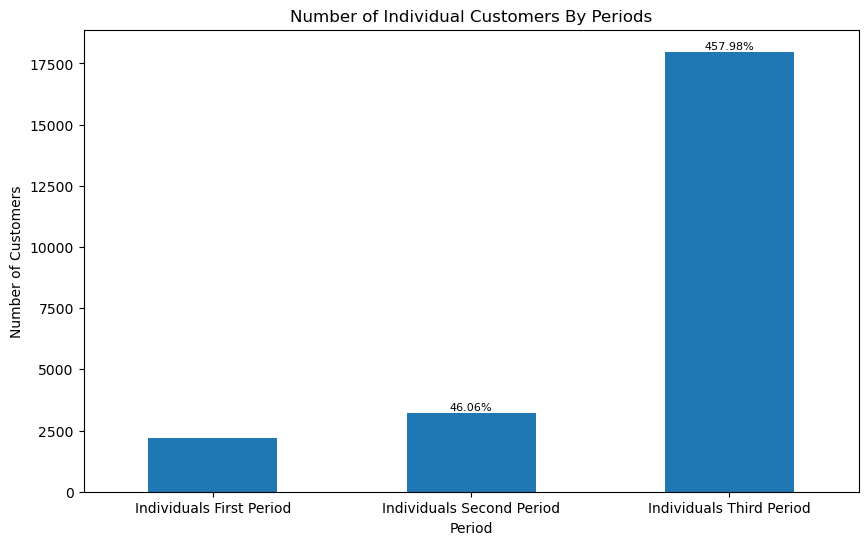

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))

result.set_index('Period').plot(kind='bar', stacked=True, ax=ax, legend=False, rot=0)

# Calculate percentage growth and display text labels on the plot
for i in range(1, len(result)):
    current_period = result['NumberOfCustomers'].iloc[i]
    prev_period = result['NumberOfCustomers'].iloc[i - 1]
    growth_percentage = ((current_period - prev_period) / prev_period) * 100

    ax.text(
        i,
        current_period + 1,
        f'{growth_percentage:.2f}%',
        ha='center',
        va='bottom',
        fontsize=8  
    )

ax.set_xlabel('Period')
ax.set_ylabel('Number of Customers')
ax.set_title('Number of Individual Customers By Periods')

plt.show()

In [23]:
#Find Total Sale for Store Customers by Period

TotalSales_ByPeriod_StoreCustomers = """

WITH TotalSales_ByPeriod_StoreCustomers AS (
    SELECT
        A.SalesOrderID,
        SUM(A.OrderQty) AS TotalQty,
        SUM(A.LineTotal) AS TotalSales,
        B.CustomerID,
        B.OnlineOrderFlag,
		CASE
        WHEN B.OrderDate >= '2011-05-31' AND B.OrderDate <= '2012-05-29' AND B.OnlineOrderFlag = 0 THEN 'Stores First Period'
        WHEN B.OrderDate >= '2012-05-30' AND B.OrderDate <= '2013-05-29' AND B.OnlineOrderFlag = 0 THEN 'Stores Second Period'
        WHEN B.OrderDate >= '2013-05-30' AND B.OrderDate <= '2014-06-30' AND B.OnlineOrderFlag = 0 THEN 'Stores Third Period'
    END AS Period
    FROM
        Sales.SalesOrderDetail AS A
    LEFT JOIN
        Sales.SalesOrderHeader AS B ON A.SalesOrderID = B.SalesOrderID
    GROUP BY
        A.SalesOrderID, B.CustomerID, B.OnlineOrderFlag,
		CASE
        WHEN B.OrderDate >= '2011-05-31' AND B.OrderDate <= '2012-05-29' AND B.OnlineOrderFlag = 0 THEN 'Stores First Period'
        WHEN B.OrderDate >= '2012-05-30' AND B.OrderDate <= '2013-05-29' AND B.OnlineOrderFlag = 0 THEN 'Stores Second Period'
        WHEN B.OrderDate >= '2013-05-30' AND B.OrderDate <= '2014-06-30' AND B.OnlineOrderFlag = 0 THEN 'Stores Third Period'
    END
)
SELECT
	[Period],
	SUM(TotalSales) AS TotalSales
FROM TotalSales_ByPeriod_StoreCustomers
WHERE [Period] IS NOT NULL
GROUP BY [Period]
ORDER BY [Period]
"""

result = pd.read_sql(TotalSales_ByPeriod_StoreCustomers, engine)

print(result)

                 Period  TotalSales
0   Stores First Period  16,288,442
1  Stores Second Period  27,921,671
2   Stores Third Period  36,277,592


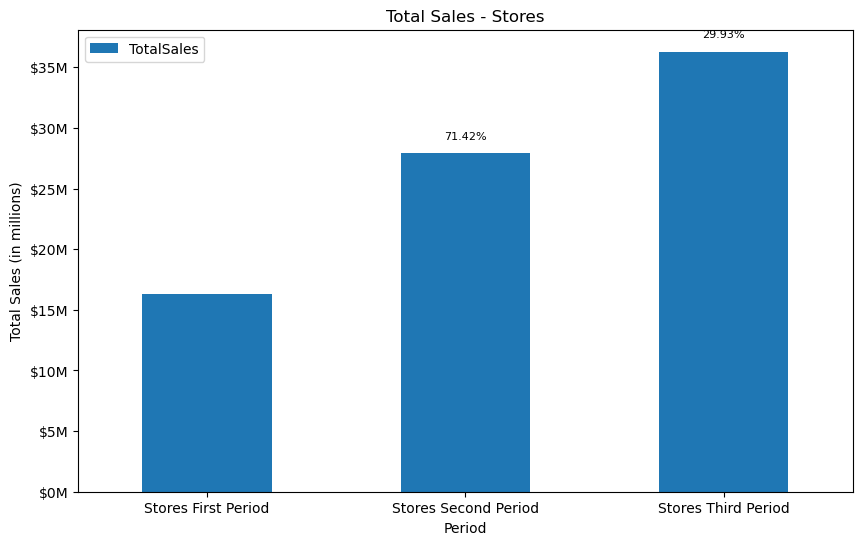

In [24]:
fig, ax = plt.subplots(figsize=(10, 6))

# Stacked bar chart
result.set_index('Period').plot(kind='bar', stacked=True, ax=ax, legend=True, rot=0)

# Format y-axis ticks in millions
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x / 1e6:.0f}M'))

ax.set_xlabel('Period')
ax.set_ylabel('Total Sales (in millions)')
ax.set_title('Total Sales - Stores')

# Calculate percentage growth and display on the plot
for i in range(1, len(result)):
    for j, column in enumerate(result.columns[1:]):  # Skip the first column ('Period')
        current_sales = result[column].iloc[i]
        prev_sales = result[column].iloc[i - 1]
        growth_percentage = ((current_sales - prev_sales) / prev_sales) * 100

        ax.text(
            i,
            result.iloc[i][column] + 1e6,
            f'{growth_percentage:.2f}%',
            ha='center',
            va='bottom',
            fontsize=8  # Adjust font size as needed
        )

plt.show()

In [25]:
#Find Total Sales for Individual Customers by Period

TotalSales_ByPeriod_IndividualCustomers = """

WITH TotalSales_ByPeriod_IndividualCustomers AS (
    SELECT
        A.SalesOrderID,
        SUM(A.OrderQty) AS TotalQty,
        SUM(A.LineTotal) AS TotalSales,
        B.CustomerID,
        B.OnlineOrderFlag,
		CASE
        WHEN B.OrderDate >= '2011-05-31' AND B.OrderDate <= '2012-05-29' AND B.OnlineOrderFlag = 1 THEN 'Individuals First Period'
        WHEN B.OrderDate >= '2012-05-30' AND B.OrderDate <= '2013-05-29' AND B.OnlineOrderFlag = 1 THEN 'Individuals Second Period'
        WHEN B.OrderDate >= '2013-05-30' AND B.OrderDate <= '2014-06-30' AND B.OnlineOrderFlag = 1 THEN 'Individuals Third Period'
    END AS Period
    FROM
        Sales.SalesOrderDetail AS A
    LEFT JOIN
        Sales.SalesOrderHeader AS B ON A.SalesOrderID = B.SalesOrderID
    GROUP BY
        A.SalesOrderID, B.CustomerID, B.OnlineOrderFlag,
		CASE
        WHEN B.OrderDate >= '2011-05-31' AND B.OrderDate <= '2012-05-29' AND B.OnlineOrderFlag = 1 THEN 'Individuals First Period'
        WHEN B.OrderDate >= '2012-05-30' AND B.OrderDate <= '2013-05-29' AND B.OnlineOrderFlag = 1 THEN 'Individuals Second Period'
        WHEN B.OrderDate >= '2013-05-30' AND B.OrderDate <= '2014-06-30' AND B.OnlineOrderFlag = 1 THEN 'Individuals Third Period'
    END
)
SELECT
	[Period],
	SUM(TotalSales) AS TotalSales
FROM TotalSales_ByPeriod_IndividualCustomers 
WHERE [Period] IS NOT NULL
GROUP BY [Period]
ORDER BY [Period]
"""

result = pd.read_sql(TotalSales_ByPeriod_IndividualCustomers, engine)

# Display the result
print(result)

                      Period  TotalSales
0   Individuals First Period   7,072,084
1  Individuals Second Period   5,762,134
2   Individuals Third Period  16,524,459


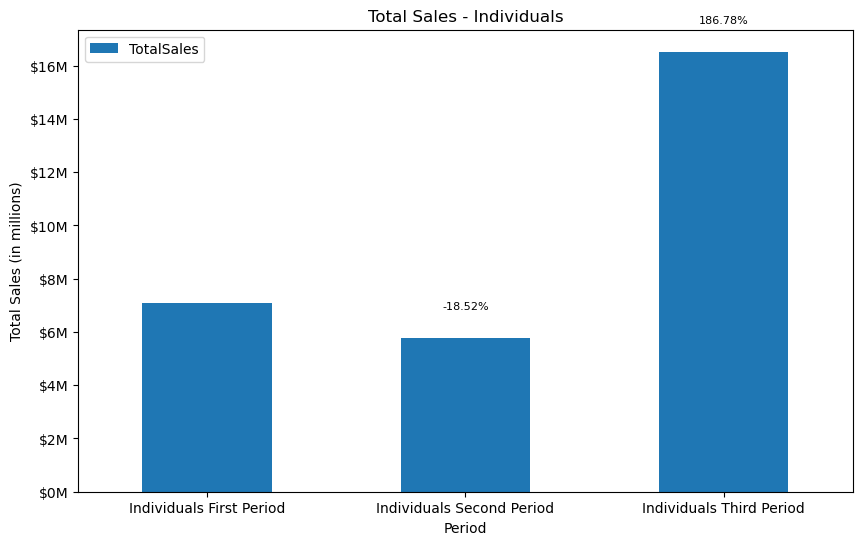

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))

# Stacked bar chart
result.set_index('Period').plot(kind='bar', stacked=True, ax=ax, legend=True, rot=0)

# Format y-axis ticks in millions
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x / 1e6:.0f}M'))

ax.set_xlabel('Period')
ax.set_ylabel('Total Sales (in millions)')
ax.set_title('Total Sales - Individuals')


# Calculate percentage growth and display on the plot
for i in range(1, len(result)):
    current_sales = result['TotalSales'].iloc[i]
    prev_sales = result['TotalSales'].iloc[i - 1]
    growth_percentage = ((current_sales - prev_sales) / prev_sales) * 100

    ax.text(
        i,
        current_sales + 1e6,
        f'{growth_percentage:.2f}%',
        ha='center',
        va='bottom',
        fontsize=8  
    )

plt.show()

In [27]:
#Find Mean Per Store Customer By Period

MeanPerCustomer_ByPeriod_StoreCustomers = """

WITH MeanPerCustomer_ByPeriod AS (
SELECT
    CustomerID,
    COUNT(SalesOrderID) AS TotalOrders,
    SUM(SubTotal) AS TotalSales,
    CASE
        WHEN OrderDate >= '2011-05-31' AND OrderDate <= '2012-05-29' AND OnlineOrderFlag = 0 THEN 'Stores First Period'
        WHEN OrderDate >= '2012-05-30' AND OrderDate <= '2013-05-29' AND OnlineOrderFlag = 0 THEN 'Stores Second Period'
        WHEN OrderDate >= '2013-05-30' AND OrderDate <= '2014-06-30' AND OnlineOrderFlag = 0 THEN 'Stores Third Period'
    END AS Period
FROM
    Sales.SalesOrderHeader
GROUP BY
    CustomerID,
    CASE
        WHEN OrderDate >= '2011-05-31' AND OrderDate <= '2012-05-29' AND OnlineOrderFlag = 0 THEN 'Stores First Period'
        WHEN OrderDate >= '2012-05-30' AND OrderDate <= '2013-05-29' AND OnlineOrderFlag = 0 THEN 'Stores Second Period'
        WHEN OrderDate >= '2013-05-30' AND OrderDate <= '2014-06-30' AND OnlineOrderFlag = 0 THEN 'Stores Third Period'
    END
)
SELECT [Period],
	SUM(TotalSales) / COUNT(CustomerID) AS MeanCustomer
FROM MeanPerCustomer_ByPeriod
WHERE Period IS NOT NULL
GROUP BY [Period]
ORDER BY [Period]
"""

result = pd.read_sql(MeanPerCustomer_ByPeriod_StoreCustomers , engine)

print(result)

                 Period  MeanCustomer
0   Stores First Period        78,310
1  Stores Second Period        76,498
2   Stores Third Period        73,585


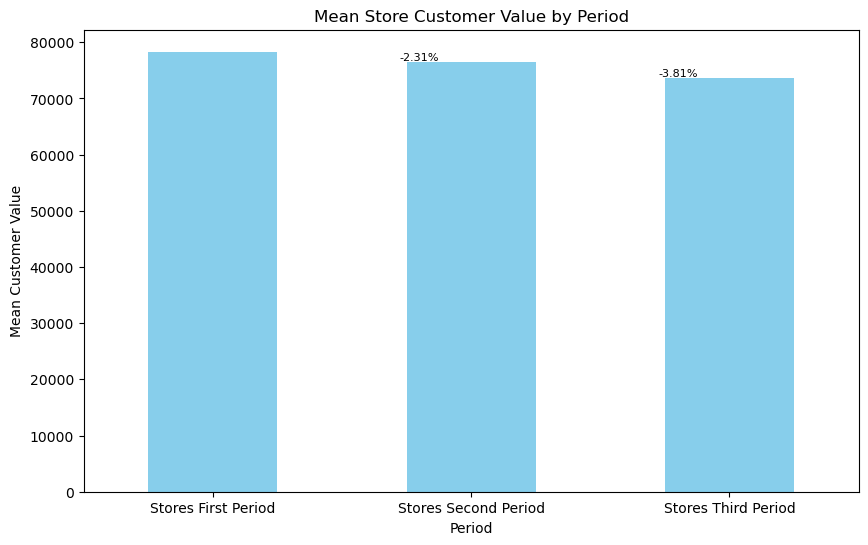

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))
result.plot(x='Period', y='MeanCustomer', kind='bar', ax=ax, legend=False, color='skyblue', rot=0)

ax.set_xlabel('Period')
ax.set_ylabel('Mean Customer Value')
ax.set_title('Mean Store Customer Value by Period')

# Calculate percentage growth and display on the plot
for i in range(1, len(result)):
    current_mean_customer = result['MeanCustomer'].iloc[i]
    prev_mean_customer = result['MeanCustomer'].iloc[i - 1]
    growth_percentage = ((current_mean_customer - prev_mean_customer) / prev_mean_customer) * 100

    ax.text(
        i - 0.2,
        current_mean_customer + 0.1,
        f'{growth_percentage:.2f}%',
        ha='center',
        va='bottom',
        fontsize=8  
    )

plt.show()

In [29]:
#Find Mean Per Individual Customer By Period

TotalCustomers_TotalSales_TotalOrder_ByPeriod_ByCustomerType1 = """

WITH MeanPerCustomer_ByPeriod AS (
SELECT
    CustomerID,
    COUNT(SalesOrderID) AS TotalOrders,
    SUM(SubTotal) AS TotalSales,
    CASE
        WHEN OrderDate >= '2011-05-31' AND OrderDate <= '2012-05-29' AND OnlineOrderFlag = 1 THEN 'Individuals First Period'
        WHEN OrderDate >= '2012-05-30' AND OrderDate <= '2013-05-29' AND OnlineOrderFlag = 1 THEN 'Individuals Second Period'
        WHEN OrderDate >= '2013-05-30' AND OrderDate <= '2014-06-30' AND OnlineOrderFlag = 1 THEN 'Individuals Third Period'
END AS Period
FROM
    Sales.SalesOrderHeader
GROUP BY
    CustomerID,
    CASE
        WHEN OrderDate >= '2011-05-31' AND OrderDate <= '2012-05-29' AND OnlineOrderFlag = 1 THEN 'Individuals First Period'
        WHEN OrderDate >= '2012-05-30' AND OrderDate <= '2013-05-29' AND OnlineOrderFlag = 1 THEN 'Individuals Second Period'
        WHEN OrderDate >= '2013-05-30' AND OrderDate <= '2014-06-30' AND OnlineOrderFlag = 1 THEN 'Individuals Third Period'
    END
)
SELECT [Period],
	SUM(TotalSales) / COUNT(CustomerID) AS MeanCustomer
FROM MeanPerCustomer_ByPeriod
WHERE [Period] IS NOT NULL
GROUP BY [Period]
ORDER BY [Period]

"""

result = pd.read_sql(TotalCustomers_TotalSales_TotalOrder_ByPeriod_ByCustomerType1, engine)

print(result)

                      Period  MeanCustomer
0   Individuals First Period         3,206
1  Individuals Second Period         1,788
2   Individuals Third Period           919


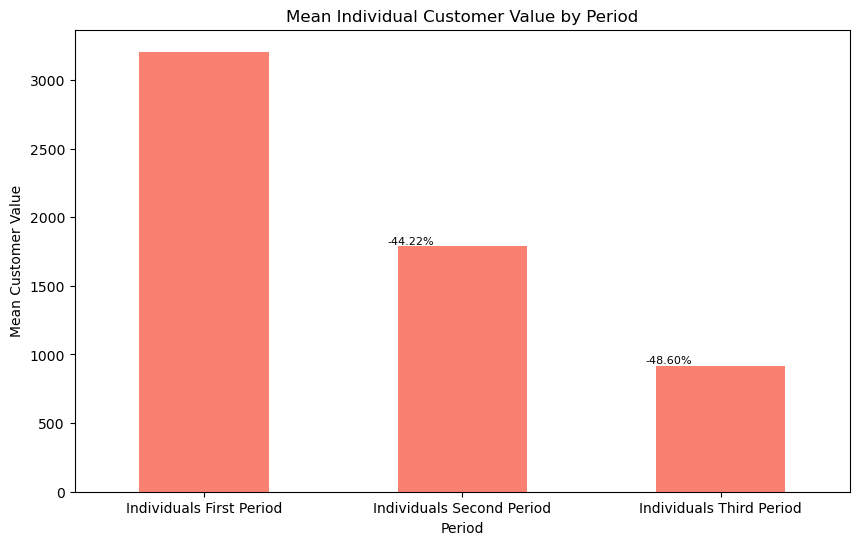

In [30]:
fig, ax = plt.subplots(figsize=(10, 6))
result.plot(x='Period', y='MeanCustomer', kind='bar', ax=ax, legend=False, color='salmon', rot=0)

ax.set_xlabel('Period')
ax.set_ylabel('Mean Customer Value')
ax.set_title('Mean Individual Customer Value by Period')

# Calculate percentage growth and display on the plot
for i in range(1, len(result)):
    current_mean_customer = result['MeanCustomer'].iloc[i]
    prev_mean_customer = result['MeanCustomer'].iloc[i - 1]
    growth_percentage = ((current_mean_customer - prev_mean_customer) / prev_mean_customer) * 100

    ax.text(
        i - 0.2,
        current_mean_customer + 0.1,
        f'{growth_percentage:.2f}%',
        ha='center',
        va='bottom',
        fontsize=8 
    )

plt.show()

In [31]:
#Sales to Stores to find Standart Deviation

SalesToStores = """

WITH TotalCustomers_TotalSales_TotalOrder AS (
SELECT
    CustomerID,
    COUNT(SalesOrderID) AS TotalOrders,
    SUM(SubTotal) AS TotalSales,
    CASE
        WHEN OrderDate >= '2013-05-30' AND OrderDate <= '2014-06-30' AND OnlineOrderFlag = 0 THEN 'Stores First Period'
END AS Period
FROM
    Sales.SalesOrderHeader
GROUP BY
    CustomerID,
    CASE
        WHEN OrderDate >= '2013-05-30' AND OrderDate <= '2014-06-30' AND OnlineOrderFlag = 0 THEN 'Stores First Period'
    END
)
SELECT CustomerID,
	[Period],
	SUM(TotalSales) AS TotalSales
FROM TotalCustomers_TotalSales_TotalOrder
WHERE Period IS NOT NULL
GROUP BY CustomerID, [Period]
ORDER BY [Period]


"""

result = pd.read_sql(SalesToStores, engine)

print(result)

     CustomerID               Period  TotalSales
0         29485  Stores First Period     112,889
1         29486  Stores First Period     116,375
2         29487  Stores First Period       5,830
3         29488  Stores First Period     221,170
4         29489  Stores First Period     275,644
..          ...                  ...         ...
488       30114  Stores First Period       7,689
489       30115  Stores First Period       3,003
490       30116  Stores First Period     187,114
491       30117  Stores First Period     289,777
492       30118  Stores First Period     136,734

[493 rows x 3 columns]


In [32]:
# Calculate Standart Deviation / Change the period in code to see the results for other periods

from io import StringIO

sql_result = """
WITH TotalCustomers_TotalSales_TotalOrder AS (
SELECT
    CustomerID,
    COUNT(SalesOrderID) AS TotalOrders,
    SUM(SubTotal) AS TotalSales,
    CASE
        WHEN OrderDate >= '2013-05-30' AND OrderDate <= '2014-06-30' AND OnlineOrderFlag = 0 THEN 'Stores First Period'
END AS Period
FROM
    Sales.SalesOrderHeader
GROUP BY
    CustomerID,
    CASE
        WHEN OrderDate >= '2013-05-30' AND OrderDate <= '2014-06-30' AND OnlineOrderFlag = 0 THEN 'Stores First Period'
    END
)
SELECT CustomerID,
	[Period],
	SUM(TotalSales) AS TotalSales
FROM TotalCustomers_TotalSales_TotalOrder
WHERE Period IS NOT NULL
GROUP BY CustomerID, [Period]
ORDER BY [Period]
"""

df = pd.read_sql(sql_result, engine)

print(df.columns)

# Calculate the standard deviation
std_deviation = df['TotalSales'].std()

print("Standard Deviation:", std_deviation)

Index(['CustomerID', 'Period', 'TotalSales'], dtype='object')
Standard Deviation: 94784.2756016909


In [33]:
# Find if there is a significant difference in mean price for category Bikes between the second and the third periods

n1 = 208
n2 = 493
my1 = 78310
my2 = 73585
s1 = 80287
s2 = 94784
z_critical = 1.64

# Calculate the Z-value
z_value = (my1 - my2) / math.sqrt((s1**2 / n1) + (s2**2 / n2))

print(z_value)

# Check if the Z-value is in the critical region
if abs(z_value) > z_critical:
    print("There is a significant difference between the means.")
else:
    print("There is no significant difference between the means.")

0.6735340249566267
There is no significant difference between the means.


In [34]:
#Sales to Individuals to find Standart Deviation

SalesToIndividuals = """

WITH TotalCustomers_TotalSales_TotalOrder AS (
SELECT
    CustomerID,
    COUNT(SalesOrderID) AS TotalOrders,
    SUM(SubTotal) AS TotalSales,
    CASE
        WHEN OrderDate >= '2011-05-30' AND OrderDate <= '2012-05-29' AND OnlineOrderFlag = 1 THEN 'Individuals First Period'
END AS Period
FROM
    Sales.SalesOrderHeader
GROUP BY
    CustomerID,
    CASE
        WHEN OrderDate >= '2011-05-30' AND OrderDate <= '2012-05-29' AND OnlineOrderFlag = 1 THEN 'Individuals First Period'
    END
)
SELECT CustomerID,
	[Period],
	SUM(TotalSales) AS TotalSales
FROM TotalCustomers_TotalSales_TotalOrder
WHERE Period IS NOT NULL
GROUP BY CustomerID, [Period]
ORDER BY [Period]


"""

result = pd.read_sql(SalesToIndividuals, engine)

print(result)

      CustomerID                    Period  TotalSales
0          11000  Individuals First Period       3,400
1          11001  Individuals First Period       3,375
2          11002  Individuals First Period       3,400
3          11003  Individuals First Period       3,400
4          11004  Individuals First Period       3,400
...          ...                       ...         ...
2201       29467  Individuals First Period       3,375
2202       29474  Individuals First Period       3,375
2203       29475  Individuals First Period       3,400
2204       29476  Individuals First Period       3,400
2205       29481  Individuals First Period       3,375

[2206 rows x 3 columns]


In [35]:
# Calculate Standart Deviation / Change the period in code to see the results for other periods

sql_result = """
WITH TotalCustomers_TotalSales_TotalOrder AS (
SELECT
    CustomerID,
    COUNT(SalesOrderID) AS TotalOrders,
    SUM(SubTotal) AS TotalSales,
    CASE
        WHEN OrderDate >= '2011-05-30' AND OrderDate <= '2012-05-29' AND OnlineOrderFlag = 1 THEN 'Individuals First Period'
END AS Period
FROM
    Sales.SalesOrderHeader
GROUP BY
    CustomerID,
    CASE
        WHEN OrderDate >= '2011-05-30' AND OrderDate <= '2012-05-29' AND OnlineOrderFlag = 1 THEN 'Individuals First Period'
    END
)
SELECT CustomerID,
	[Period],
	SUM(TotalSales) AS TotalSales
FROM TotalCustomers_TotalSales_TotalOrder
WHERE Period IS NOT NULL
GROUP BY CustomerID, [Period]
ORDER BY [Period]
"""

df = pd.read_sql(sql_result, engine)

print(df.columns)

# Calculate the standard deviation
std_deviation = df['TotalSales'].std()

print("Standard Deviation:", std_deviation)

Index(['CustomerID', 'Period', 'TotalSales'], dtype='object')
Standard Deviation: 917.3641068103049


In [36]:
# Find if there is a significant difference in mean price for category Bikes between the second and the third periods
n1 = 2206
n2 = 17978
my1 = 3206
my2 = 919
s1 = 917
s2 = 1233
z_critical = 1.64

# Calculate the Z-value
z_value = (my1 - my2) / math.sqrt((s1**2 / n1) + (s2**2 / n2))

print(z_value)

if abs(z_value) > z_critical:
    print("There is a significant difference between the means.")
else:
    print("There is no significant difference between the means.")

105.97205257158257
There is a significant difference between the means.


In [37]:
# Find Total Sale / Total Order Qty By Period And By Category

UniqueProduct_By_ProductCategory_ByPeriod = """

WITH Sold_UniqueProduct_By_ProductCategory_ByPeriod AS (
SELECT 
    ProductID,
    SUM(LineTotal) AS TotalSales,
    SUM(OrderQty) AS TotalQty,
    CASE
        WHEN ModifiedDate >= '2011-05-31' AND ModifiedDate <= '2012-05-29' THEN 'First Period'
        WHEN ModifiedDate >= '2012-05-30' AND ModifiedDate <= '2013-05-29' THEN 'Second Period'
        WHEN ModifiedDate >= '2013-05-30' AND ModifiedDate <= '2014-06-30' THEN 'Third Period'
    END AS Period
FROM 
    Sales.SalesOrderDetail
GROUP BY 
    ProductID,
    CASE
        WHEN ModifiedDate >= '2011-05-31' AND ModifiedDate <= '2012-05-29' THEN 'First Period'
        WHEN ModifiedDate >= '2012-05-30' AND ModifiedDate <= '2013-05-29' THEN 'Second Period'
        WHEN ModifiedDate >= '2013-05-30' AND ModifiedDate <= '2014-06-30' THEN 'Third Period'
    END
)
SELECT B.CategoryName,
	A.[Period],
	COUNT(A.ProductID) AS NumberOfProducts,
	SUM(A.TotalSales) AS TotalSales,
	SUM(A.TotalQty) As TotalQty
FROM Sold_UniqueProduct_By_ProductCategory_ByPeriod AS A
LEFT JOIN (
    SELECT
        A.ProductID,
        A.Name AS ProductName,
        A.ProductSubcategoryID,
        B.ProductCategoryID,
        B.Name AS SubCategoryName,
        C.Name AS CategoryName,
		A.MakeFlag,
		A.SellStartDate,
		A.SellEndDate
    FROM
        Production.Product AS A
        LEFT JOIN Production.ProductSubCategory AS B ON A.ProductSubcategoryID = B.ProductSubcategoryID
        LEFT JOIN Production.ProductCategory AS C ON B.ProductCategoryID = C.ProductCategoryID
) AS B
ON A.ProductID = B.ProductID
GROUP BY B.CategoryName, A.[Period]
ORDER BY B.CategoryName

"""

result = pd.read_sql(UniqueProduct_By_ProductCategory_ByPeriod , engine)
result

,CategoryName,Period,NumberOfProducts,TotalSales,TotalQty
0,Accessories,First Period,3,"36,815",1825
1,Accessories,Second Period,5,"124,433",7083
2,Accessories,Third Period,23,"1,110,825",53024
3,Bikes,First Period,30,"22,090,618",15282
4,Bikes,Second Period,35,"28,179,554",31061
5,Bikes,Third Period,68,"44,381,000",43925
6,Clothing,First Period,6,"66,328",4084
7,Clothing,Second Period,19,"750,716",24880
8,Clothing,Third Period,28,"1,303,499",44706
9,Components,First Period,21,"1,166,765",2905


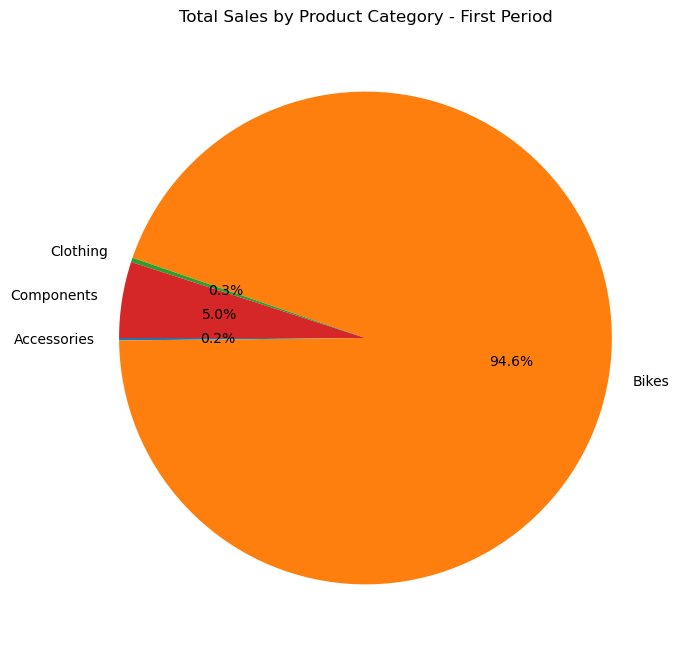

In [38]:
# Filter data for the period
first_period_data = result[result['Period'] == 'First Period']

category_sales = first_period_data.groupby('CategoryName')['TotalSales'].sum()

plt.figure(figsize=(8, 8))
plt.pie(category_sales, labels=category_sales.index, autopct='%1.1f%%', startangle=180)
plt.title('Total Sales by Product Category - First Period')
plt.show()

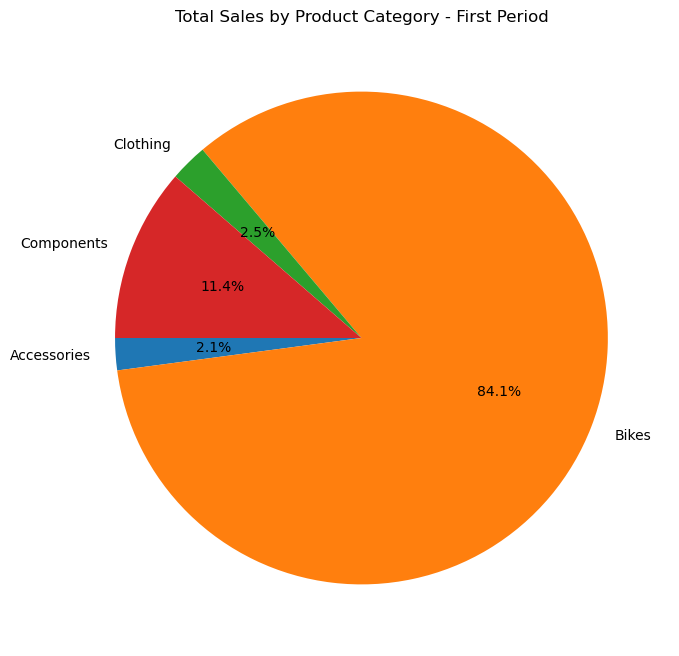

In [39]:
# Filter data for the period
first_period_data = result[result['Period'] == 'Third Period']

category_sales = first_period_data.groupby('CategoryName')['TotalSales'].sum()

plt.figure(figsize=(8, 8))
plt.pie(category_sales, labels=category_sales.index, autopct='%1.1f%%', startangle=180)
plt.title('Total Sales by Product Category - First Period')
plt.show()

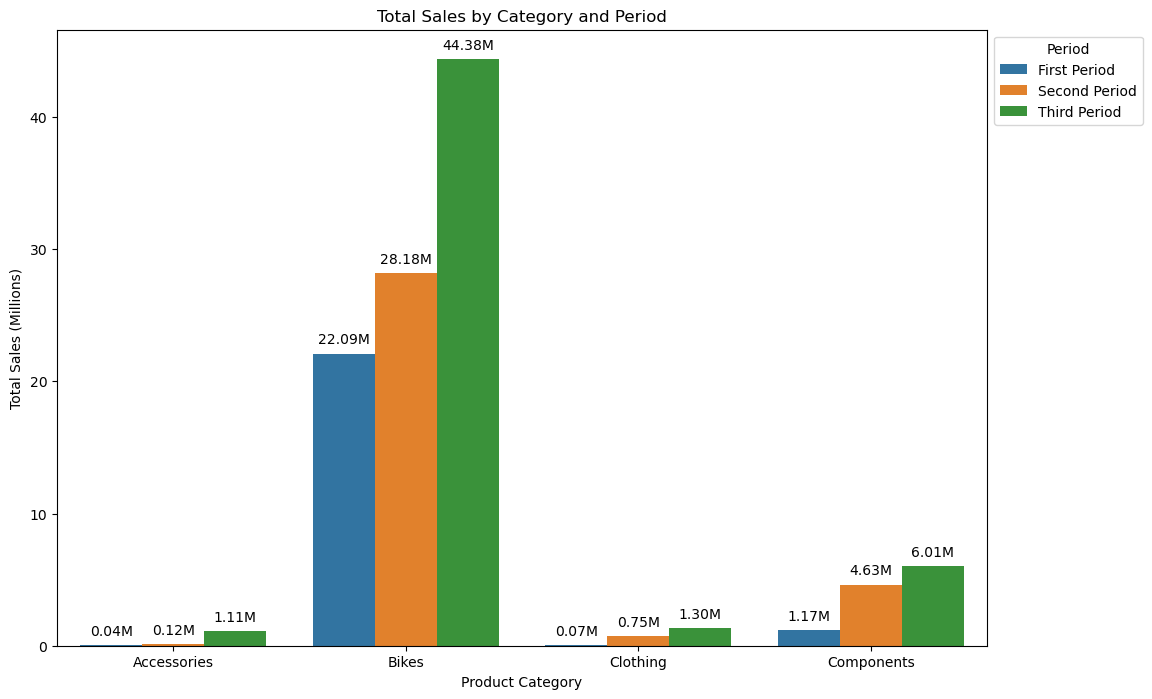

In [40]:
result = pd.read_sql(UniqueProduct_By_ProductCategory_ByPeriod, engine)

# Konvertera TotalSales till miljoner
result['TotalSales_Millions'] = result['TotalSales'] / 1000000

plt.figure(figsize=(12, 8))
ax = sns.barplot(x='CategoryName', y='TotalSales_Millions', hue='Period', data=result)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}M', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 10),
                textcoords='offset points')

plt.xlabel('Product Category')
plt.ylabel('Total Sales (Millions)')
plt.title('Total Sales by Category and Period')
plt.legend(title='Period', loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

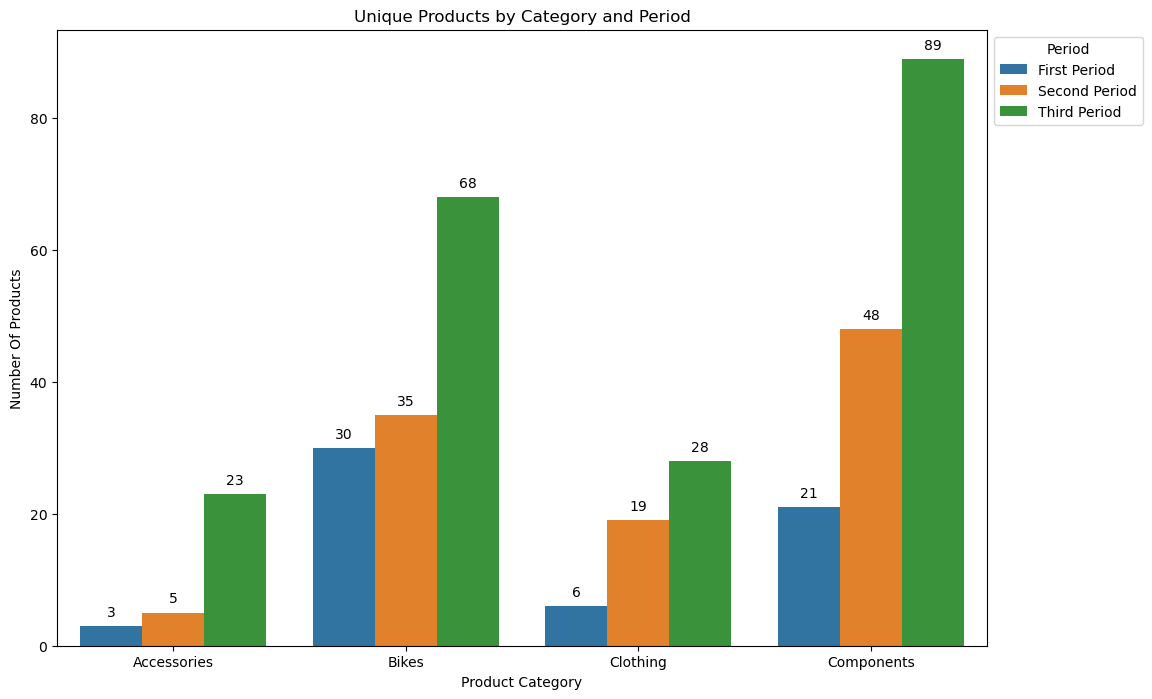

In [41]:
result = pd.read_sql(UniqueProduct_By_ProductCategory_ByPeriod, engine)

plt.figure(figsize=(12, 8))
ax = sns.barplot(x='CategoryName', y='NumberOfProducts', hue='Period', data=result)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 10),
                textcoords='offset points')

plt.xlabel('Product Category')
plt.ylabel('Number Of Products')
plt.title('Unique Products by Category and Period')
plt.legend(title='Period', loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

In [42]:
MeanPrice_ByCategory_ByPeriod = """

WITH MeanPrice_ByCategory_ByPeriod AS (
SELECT 
    ProductID,
    SUM(LineTotal) AS TotalSales,
    SUM(OrderQty) AS TotalQty,
    CASE
        WHEN ModifiedDate >= '2011-05-31' AND ModifiedDate <= '2012-05-29' THEN 'First Period'
        WHEN ModifiedDate >= '2012-05-30' AND ModifiedDate <= '2013-05-29' THEN 'Second Period'
        WHEN ModifiedDate >= '2013-05-30' AND ModifiedDate <= '2014-06-30' THEN 'Third Period'
    END AS Period
FROM 
    Sales.SalesOrderDetail
GROUP BY 
    ProductID,
    CASE
        WHEN ModifiedDate >= '2011-05-31' AND ModifiedDate <= '2012-05-29' THEN 'First Period'
        WHEN ModifiedDate >= '2012-05-30' AND ModifiedDate <= '2013-05-29' THEN 'Second Period'
        WHEN ModifiedDate >= '2013-05-30' AND ModifiedDate <= '2014-06-30' THEN 'Third Period'
    END
)
SELECT B.CategoryName,
	A.[Period],
	SUM(A.TotalSales) / SUM(A.TotalQty) AS MeanPrice
FROM MeanPrice_ByCategory_ByPeriod AS A
LEFT JOIN (
    SELECT
        A.ProductID,
        A.Name AS ProductName,
        A.ProductSubcategoryID,
        B.ProductCategoryID,
        B.Name AS SubCategoryName,
        C.Name AS CategoryName,
		A.MakeFlag,
		A.SellStartDate,
		A.SellEndDate
    FROM
        Production.Product AS A
        LEFT JOIN Production.ProductSubCategory AS B ON A.ProductSubcategoryID = B.ProductSubcategoryID
        LEFT JOIN Production.ProductCategory AS C ON B.ProductCategoryID = C.ProductCategoryID
) AS B
ON A.ProductID = B.ProductID 
GROUP BY B.CategoryName, A.[Period]
ORDER BY B.CategoryName
"""

result = pd.read_sql(MeanPrice_ByCategory_ByPeriod, engine)

print(result)

   CategoryName         Period  MeanPrice
0   Accessories   First Period         20
1   Accessories  Second Period         18
2   Accessories   Third Period         21
3         Bikes   First Period      1,446
4         Bikes  Second Period        907
5         Bikes   Third Period      1,010
6      Clothing   First Period         16
7      Clothing  Second Period         30
8      Clothing   Third Period         29
9    Components   First Period        402
10   Components  Second Period        242
11   Components   Third Period        223


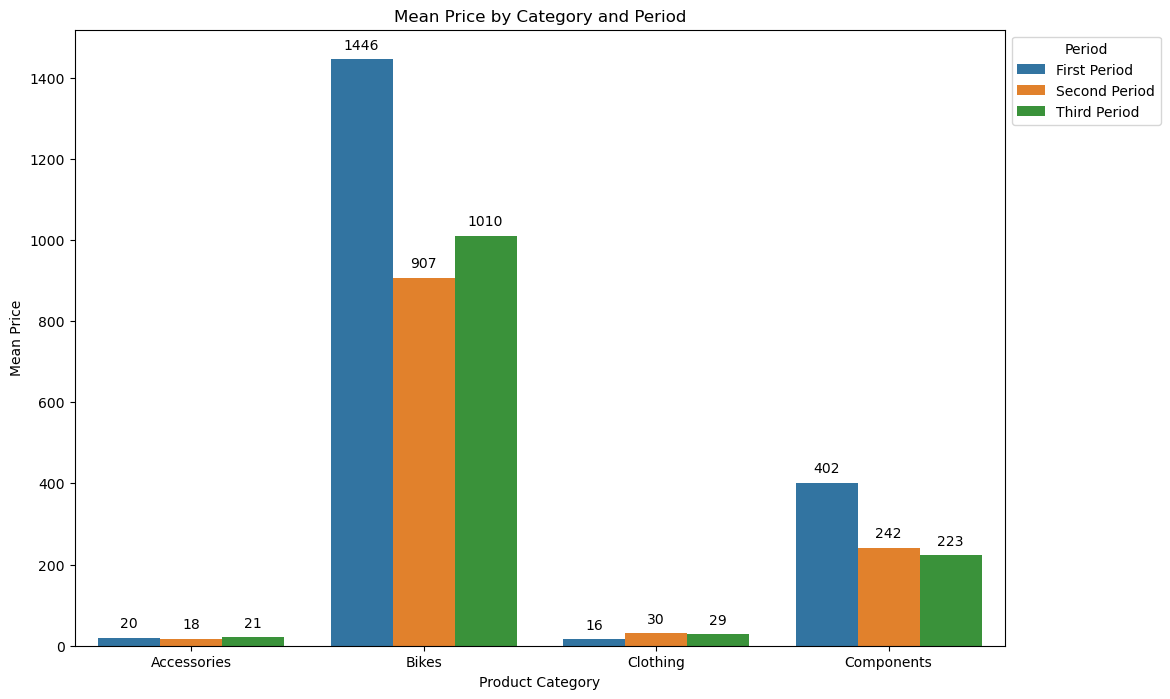

In [43]:
result = pd.read_sql(MeanPrice_ByCategory_ByPeriod, engine)

plt.figure(figsize=(12, 8))
ax = sns.barplot(x='CategoryName', y='MeanPrice', hue='Period', data=result)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 10),
                textcoords='offset points')

plt.xlabel('Product Category')
plt.ylabel('Mean Price')
plt.title('Mean Price by Category and Period')
plt.legend(title='Period', loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

In [44]:
# Find Number of Products purchased per Customer and Period

UniqueProduct_By_ProductCategory_ByPeriod = """

WITH TotalCustomers_TotalSales_TotalOrder AS (
SELECT
    A.CustomerID,
	SUM(B.OrderQty) AS TotalQty,
    COUNT(A.SalesOrderID) AS TotalOrders,
    SUM(A.SubTotal) AS TotalSales,
    CASE
        WHEN A.OrderDate >= '2011-05-31' AND A.OrderDate <= '2012-05-29' AND A.OnlineOrderFlag = 0 THEN 'Stores First Period'
        WHEN A.OrderDate >= '2011-05-31' AND A.OrderDate <= '2012-05-29' AND A.OnlineOrderFlag = 1 THEN 'Private First Period'
        WHEN A.OrderDate >= '2012-05-30' AND A.OrderDate <= '2013-05-29' AND A.OnlineOrderFlag = 0 THEN 'Stores Second Period'
        WHEN A.OrderDate >= '2012-05-30' AND A.OrderDate <= '2013-05-29' AND A.OnlineOrderFlag = 1 THEN 'Private Second Period'
        WHEN A.OrderDate >= '2013-05-30' AND A.OrderDate <= '2014-06-30' AND A.OnlineOrderFlag = 0 THEN 'Stores Third Period'
        WHEN A.OrderDate >= '2013-05-30' AND A.OrderDate <= '2014-06-30' AND A.OnlineOrderFlag = 1 THEN 'Private Third Period'
 END AS Period
FROM
    Sales.SalesOrderHeader AS A
LEFT JOIN Sales.SalesOrderDetail AS B
ON A.SalesOrderID = B.SalesOrderID
GROUP BY
    CustomerID,
    CASE
        WHEN A.OrderDate >= '2011-05-31' AND A.OrderDate <= '2012-05-29' AND A.OnlineOrderFlag = 0 THEN 'Stores First Period'
        WHEN A.OrderDate >= '2011-05-31' AND A.OrderDate <= '2012-05-29' AND A.OnlineOrderFlag = 1 THEN 'Private First Period'
        WHEN A.OrderDate >= '2012-05-30' AND A.OrderDate <= '2013-05-29' AND A.OnlineOrderFlag = 0 THEN 'Stores Second Period'
        WHEN A.OrderDate >= '2012-05-30' AND A.OrderDate <= '2013-05-29' AND A.OnlineOrderFlag = 1 THEN 'Private Second Period'
        WHEN A.OrderDate >= '2013-05-30' AND A.OrderDate <= '2014-06-30' AND A.OnlineOrderFlag = 0 THEN 'Stores Third Period'
        WHEN A.OrderDate >= '2013-05-30' AND A.OrderDate <= '2014-06-30' AND A.OnlineOrderFlag = 1 THEN 'Private Third Period'
    END
)
SELECT [Period],
	SUM(TotalQty) AS TotalSoldQty,
	COUNT(CustomerID) AS NumberOfCustomers,
	SUM(TotalQty) / COUNT(CustomerID) AS NumberOfProductsPerCustomer
FROM TotalCustomers_TotalSales_TotalOrder
GROUP BY [Period]
ORDER BY [Period]
"""

result = pd.read_sql(UniqueProduct_By_ProductCategory_ByPeriod , engine)
result

,Period,TotalSoldQty,NumberOfCustomers,NumberOfProductsPerCustomer
0,Private First Period,2206,2206,1
1,Private Second Period,3222,3222,1
2,Private Third Period,54970,17978,3
3,Stores First Period,21890,208,105
4,Stores Second Period,78959,365,216
5,Stores Third Period,113667,493,230


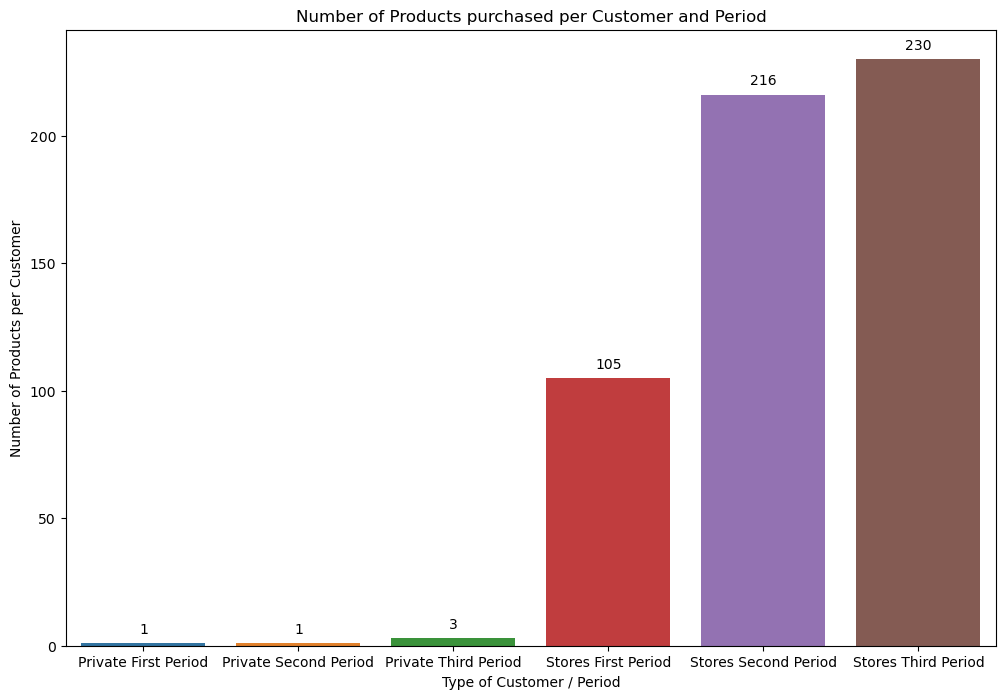

In [45]:
result = pd.read_sql(UniqueProduct_By_ProductCategory_ByPeriod, engine)

plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Period', y='NumberOfProductsPerCustomer', data=result)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 10),
                textcoords='offset points')

plt.xlabel('Type of Customer / Period')
plt.ylabel('Number of Products per Customer')
plt.title('Number of Products purchased per Customer and Period')

plt.show()

In [46]:
# Check that all products purchased by Individual Customers in First Period belongs Category Bikes

TotalSales_TotalQty_ByPeriod_ByCategory_Individuals = """

WITH CTE AS (
SELECT A.SalesOrderID,
    B.ProductID,
    B.ProductName,
	B.ProductCategoryID,
	B.CategoryName,
    SUM(A.LineTotal) AS TotalSales,
    SUM(A.OrderQty) AS TotalQty,
    CASE
        WHEN A.ModifiedDate >= '2011-05-31' AND A.ModifiedDate <= '2012-05-29' THEN 'First Period'
        WHEN A.ModifiedDate >= '2012-05-30' AND A.ModifiedDate <= '2013-05-29' THEN 'Second Period'
        WHEN A.ModifiedDate >= '2013-05-30' AND A.ModifiedDate <= '2014-06-30' THEN 'Third Period'
    END AS Period
FROM 
    Sales.SalesOrderDetail AS A
LEFT JOIN (    
SELECT
        A.ProductID,
        A.Name AS ProductName,
        A.ProductSubcategoryID,
        B.ProductCategoryID,
        B.Name AS SubCategoryName,
        C.Name AS CategoryName,
		A.MakeFlag,
		A.SellStartDate,
		A.SellEndDate
    FROM
        Production.Product AS A
        LEFT JOIN Production.ProductSubCategory AS B ON A.ProductSubcategoryID = B.ProductSubcategoryID
        LEFT JOIN Production.ProductCategory AS C ON B.ProductCategoryID = C.ProductCategoryID
) AS B
ON A.ProductID = B.ProductID
GROUP BY 
    A.SalesOrderID,
    B.ProductID,
    B.ProductName,
	B.ProductCategoryID,
	B.CategoryName,
    CASE
        WHEN ModifiedDate >= '2011-05-31' AND ModifiedDate <= '2012-05-29' THEN 'First Period'
        WHEN ModifiedDate >= '2012-05-30' AND ModifiedDate <= '2013-05-29' THEN 'Second Period'
        WHEN ModifiedDate >= '2013-05-30' AND ModifiedDate <= '2014-06-30' THEN 'Third Period'
    END
)
SELECT A.CategoryName,
	A.[Period],
	B.OnlineOrderFlag,
	SUM(A.TotalSales) AS TotalSales,
	SUM(A.TotalQty) As TotalQty
FROM CTE AS A
LEFT JOIN (
SELECT
        A.SalesOrderID,
        SUM(A.OrderQty) AS TotalQty,
        SUM(A.LineTotal) AS TotalSales,
        B.CustomerID,
        B.OnlineOrderFlag,
		CASE
        WHEN B.OrderDate >= '2011-05-31' AND B.OrderDate <= '2012-05-29' AND B.OnlineOrderFlag = 0 THEN 'Stores First Period'
        WHEN B.OrderDate >= '2012-05-30' AND B.OrderDate <= '2013-05-29' AND B.OnlineOrderFlag = 0 THEN 'Stores Second Period'
        WHEN B.OrderDate >= '2013-05-30' AND B.OrderDate <= '2014-06-30' AND B.OnlineOrderFlag = 0 THEN 'Stores Third Period'
    END AS Period
    FROM
        Sales.SalesOrderDetail AS A
    LEFT JOIN
        Sales.SalesOrderHeader AS B ON A.SalesOrderID = B.SalesOrderID
    GROUP BY
        A.SalesOrderID, B.CustomerID, B.OnlineOrderFlag,
		CASE
        WHEN B.OrderDate >= '2011-05-31' AND B.OrderDate <= '2012-05-29' AND B.OnlineOrderFlag = 0 THEN 'Stores First Period'
        WHEN B.OrderDate >= '2012-05-30' AND B.OrderDate <= '2013-05-29' AND B.OnlineOrderFlag = 0 THEN 'Stores Second Period'
        WHEN B.OrderDate >= '2013-05-30' AND B.OrderDate <= '2014-06-30' AND B.OnlineOrderFlag = 0 THEN 'Stores Third Period'
    END
) AS B
ON A.SalesOrderID = B.SalesOrderID
WHERE OnlineOrderFlag = 1
GROUP BY A.CategoryName,
	A.[Period],
	B.OnlineOrderFlag
ORDER BY 	A.[Period]
"""

result = pd.read_sql(TotalSales_TotalQty_ByPeriod_ByCategory_Individuals, engine)

print(result)

  CategoryName         Period  OnlineOrderFlag  TotalSales  TotalQty
0        Bikes   First Period             True   7,072,084      2206
1        Bikes  Second Period             True   5,762,134      3222
2  Accessories   Third Period             True     700,760     36092
3        Bikes   Third Period             True  15,483,926      9777
4     Clothing   Third Period             True     339,773      9101


In [47]:
# Check that Store Customers place the orders through Sales Representative and Individuals place orders Online

StoreID_OnlineOrderFlag = """

SELECT A.CustomerID,
	A.OnlineOrderFlag,
	B.StoreID
FROM Sales.SalesOrderHeader AS A
LEFT JOIN Sales.Customer AS B
ON A.CustomerID = B.CustomerID 
WHERE StoreID IS NOT NULL AND OnlineOrderFlag = 0
"""

result = pd.read_sql(StoreID_OnlineOrderFlag, engine)

print(result)

      CustomerID  OnlineOrderFlag  StoreID
0          29825            False     1046
1          29672            False      722
2          29734            False      852
3          29994            False     1418
4          29565            False      484
...          ...              ...      ...
3801       29715            False      814
3802       29966            False     1356
3803       29678            False      734
3804       29642            False      654
3805       30046            False     1836

[3806 rows x 3 columns]


In [48]:
# Check that all store customers who purchased orders in First Period belongs to TerritoryGroup North America
# Check that all store customers who purchased orders in Second Period belongs to TerritoryGroup North America and Europe

StoreCustomers_TerritoryGroup =  """

WITH TotalCustomers_TotalSales_TotalOrder AS (
    SELECT
        CustomerID,
        COUNT(SalesOrderID) AS TotalOrders,
        SUM(SubTotal) AS TotalSales,
        TerritoryID,
        CASE
            WHEN OrderDate >= '2011-05-31' AND OrderDate <= '2012-05-29' AND OnlineOrderFlag = 0 THEN 'Stores First Period'
            WHEN OrderDate >= '2012-05-30' AND OrderDate <= '2013-05-29' AND OnlineOrderFlag = 0 THEN 'Stores Second Period'
            WHEN OrderDate >= '2013-05-30' AND OrderDate <= '2014-06-30' AND OnlineOrderFlag = 0 THEN 'Stores Third Period'
        END AS Period
    FROM
        Sales.SalesOrderHeader
    GROUP BY
        CustomerID, TerritoryID,
        CASE
            WHEN OrderDate >= '2011-05-31' AND OrderDate <= '2012-05-29' AND OnlineOrderFlag = 0 THEN 'Stores First Period'
            WHEN OrderDate >= '2012-05-30' AND OrderDate <= '2013-05-29' AND OnlineOrderFlag = 0 THEN 'Stores Second Period'
            WHEN OrderDate >= '2013-05-30' AND OrderDate <= '2014-06-30' AND OnlineOrderFlag = 0 THEN 'Stores Third Period'
        END
)
SELECT
    A.[Period],
    A.TerritoryID, 
    B.[Group] AS TerritoryGroup,
    COUNT(A.CustomerID) AS NumberOfCustomers
FROM
    TotalCustomers_TotalSales_TotalOrder AS A
LEFT JOIN
    Sales.SalesTerritory AS B ON A.TerritoryID = B.TerritoryID
WHERE
    [Period] IS NOT NULL
GROUP BY
    A.[Period], A.TerritoryID, B.[Group]
ORDER BY
    A.[Period];
"""

result = pd.read_sql(StoreCustomers_TerritoryGroup, engine)

print(result)

                  Period  TerritoryID TerritoryGroup  NumberOfCustomers
0    Stores First Period            2  North America                 22
1    Stores First Period            6  North America                 44
2    Stores First Period            1  North America                 33
3    Stores First Period            4  North America                 48
4    Stores First Period            3  North America                 26
5    Stores First Period            5  North America                 35
6   Stores Second Period            1  North America                 55
7   Stores Second Period            6  North America                 73
8   Stores Second Period            2  North America                 34
9   Stores Second Period            7         Europe                 18
10  Stores Second Period            3  North America                 44
11  Stores Second Period            5  North America                 48
12  Stores Second Period           10         Europe            

In [49]:
# Check Hire Date for Sales Managers in Europe and Pacific regions

SalesEmployees = """

SELECT A.BusinessEntityID,
	A.JobTitle,
	B.DepartmentID,
	A.HireDate,
	C.Name AS DepartmentName
FROM HumanResources.Employee AS A
LEFT JOIN HumanResources.EmployeeDepartmentHistory AS B
ON A.BusinessEntityID = B.BusinessEntityID
LEFT JOIN HumanResources.Department AS C
ON B.DepartmentID = C.DepartmentID
WHERE B.DepartmentID = 3
 """

result = pd.read_sql(SalesEmployees, engine)

print(result)

    BusinessEntityID                      JobTitle  DepartmentID    HireDate  \
0                273       Vice President of Sales             3  2011-02-15   
1                274  North American Sales Manager             3  2011-01-04   
2                275          Sales Representative             3  2011-05-31   
3                276          Sales Representative             3  2011-05-31   
4                277          Sales Representative             3  2011-05-31   
5                278          Sales Representative             3  2011-05-31   
6                279          Sales Representative             3  2011-05-31   
7                280          Sales Representative             3  2011-05-31   
8                281          Sales Representative             3  2011-05-31   
9                282          Sales Representative             3  2011-05-31   
10               283          Sales Representative             3  2011-05-31   
11               284          Sales Repr

In [50]:
# Check the Main Sales Reason by Period

SalesReasonByPeriod = """

SELECT 
	A.SalesReasonID,
	B.Name AS ReasonName,
	COUNT(A.SalesOrderID) AS NumberOfOrders,
	CASE
        WHEN A.ModifiedDate >= '2011-05-31' AND A.ModifiedDate <= '2012-05-29' THEN 'First Period'
        WHEN A.ModifiedDate >= '2012-05-30' AND A.ModifiedDate <= '2013-05-29' THEN 'Second Period'
        WHEN A.ModifiedDate >= '2013-05-30' AND A.ModifiedDate <= '2014-06-30' THEN 'Third Period'
   END AS Period
FROM Sales.SalesOrderHeaderSalesReason AS A
LEFT JOIN Sales.SalesReason AS B
ON A.SalesReasonID = B.SalesReasonID
GROUP BY A.SalesReasonID, B.Name,
	CASE
        WHEN A.ModifiedDate >= '2011-05-31' AND A.ModifiedDate <= '2012-05-29' THEN 'First Period'
        WHEN A.ModifiedDate >= '2012-05-30' AND A.ModifiedDate <= '2013-05-29' THEN 'Second Period'
        WHEN A.ModifiedDate >= '2013-05-30' AND A.ModifiedDate <= '2014-06-30' THEN 'Third Period'
   END
ORDER BY 
	CASE
        WHEN A.ModifiedDate >= '2011-05-31' AND A.ModifiedDate <= '2012-05-29' THEN 'First Period'
        WHEN A.ModifiedDate >= '2012-05-30' AND A.ModifiedDate <= '2013-05-29' THEN 'Second Period'
        WHEN A.ModifiedDate >= '2013-05-30' AND A.ModifiedDate <= '2014-06-30' THEN 'Third Period'
   END
"""

result = pd.read_sql(SalesReasonByPeriod, engine)

print(result)

   SalesReasonID                 ReasonName  NumberOfOrders         Period
0              5               Manufacturer            1551   First Period
1              9                    Quality            1551   First Period
2              6                     Review             521  Second Period
3              2               On Promotion             993  Second Period
4              4  Television  Advertisement             722   Third Period
5             10                      Other            1395   Third Period
6              6                     Review             724   Third Period
7              5               Manufacturer             195   Third Period
8              2               On Promotion            2522   Third Period
9              1                      Price           17473   Third Period
